In [1]:
#importing required libraries and packages

import pandas as pd
import numpy as np
import numpy.random as nr
import matplotlib
import xgboost as xgb
import matplotlib.pyplot as plt
import sklearn
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn import preprocessing
import sklearn.model_selection as ms
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score

In [2]:
#printing out versions of all packages and libraries and used

print(f'pandas version is: {pd.__version__}')
print(f'numpy version is: {np.__version__}')
print(f'matplotlib version is: {matplotlib.__version__}')
print(f'sklearn version is: {sklearn.__version__}')
print(f'xgboost version is: {xgb.__version__}')

pandas version is: 1.1.2
numpy version is: 1.18.5
matplotlib version is: 3.2.2
sklearn version is: 0.22.2.post1
xgboost version is: 0.90


In [16]:
#all helper functions used

def drop_columns(traindata, *args):

    '''
    function used to drop columns.
    args:: 
      data:  dataframe to be operated on
      *args: a list of columns to be dropped from the dataframe

    return: returns a dataframe with the columns dropped
    '''
    
    columns = []
    for _ in args:
        columns.append(_)
        
    data = data.drop(columns, axis=1)
        
    return data
 
def process(data):

    '''
    function to process dataframe by replacing missing, infinity values with -999

    args:: 
      data:  dataframe to be operated on
    
    returns dataframe with replaced values
    '''
    
    cols = list(data.columns)
    for _ in cols:

        data[_] = np.where(data[_] == np.inf, -999, data[_])
        data[_] = np.where(data[_] == np.nan, -999, data[_])
        data[_] = np.where(data[_] == -np.inf, -999, data[_])
        
    return data
 
def show_evaluation(pred, true):

  '''

  function to show model performance and evaluation
  args:
    pred: predicted value(a list)
    true: actual values (a list)

  prints the custom metric performance, accuracy and F1 score of predictions

  '''

  print(f'Default score: {score(true.values, pred)}')
  print(f'Accuracy is: {accuracy_score(true, pred)}')
  print(f'F1 is: {f1_score(pred, true.values, average="weighted")}')


#Paulo Bestagini's feature augmentation technique from SEG 2016 ML competition
#Link : https://github.com/seg/2016-ml-contest/tree/master/ispl

# Feature windows concatenation function
def augment_features_window(X, N_neig):
    
    # Parameters
    N_row = X.shape[0]
    N_feat = X.shape[1]
 
    # Zero padding
    X = np.vstack((np.zeros((N_neig, N_feat)), X, (np.zeros((N_neig, N_feat)))))
 
    # Loop over windows
    X_aug = np.zeros((N_row, N_feat*(2*N_neig+1)))
    for r in np.arange(N_row)+N_neig:
        this_row = []
        for c in np.arange(-N_neig,N_neig+1):
            this_row = np.hstack((this_row, X[r+c]))
        X_aug[r-N_neig] = this_row
 
    return X_aug
 
# Feature gradient computation function
def augment_features_gradient(X, depth):
    
    # Compute features gradient
    d_diff = np.diff(depth).reshape((-1, 1))
    d_diff[d_diff==0] = 0.001
    X_diff = np.diff(X, axis=0)
    X_grad = X_diff / d_diff
        
    # Compensate for last missing value
    X_grad = np.concatenate((X_grad, np.zeros((1, X_grad.shape[1]))))
    
    return X_grad
 
# Feature augmentation function
def augment_features(X, well, depth, N_neig=1):
    
    # Augment features
    X_aug = np.zeros((X.shape[0], X.shape[1]*(N_neig*2+2)))
    for w in np.unique(well):
        w_idx = np.where(well == w)[0]
        X_aug_win = augment_features_window(X[w_idx, :], N_neig)
        X_aug_grad = augment_features_gradient(X[w_idx, :], depth[w_idx])
        X_aug[w_idx, :] = np.concatenate((X_aug_win, X_aug_grad), axis=1)
    
    # Find padded rows
    padded_rows = np.unique(np.where(X_aug[:, 0:7] == np.zeros((1, 7)))[0])
    
    return X_aug, padded_rows

def score(y_true, y_pred):

    '''
    custom metric used for evaluation
    args:
      y_true: actual prediction
      y_pred: predictions made
    '''

    S = 0.0
    y_true = y_true.astype(int)
    y_pred = y_pred.astype(int)
    for i in range(0, y_true.shape[0]):
        S -= A[y_true[i], y_pred[i]]
    return S/y_true.shape[0]

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
#should be edited to the present working directory of the user
PWD = '/content/drive/My Drive/FORCE-Lithology-Prediction/'

In [13]:
#importing penaltry matrix used for evaluation and train and test files
A = np.load(PWD + 'penalty_matrix.npy')

train = pd.read_csv(PWD + 'Train.csv', sep=';')

test = pd.read_csv(PWD + 'Test.csv', sep=';')

In [21]:
class Model():

    '''
    class to lithology prediction
    '''
    
    def __init__(self, train, test):

        '''
        takes in the train and test dataframes
        '''
        
        self.train = train
        self.test = test

        
    def __call__(self, plot = True):

      return self.fit(plot)

    def preprocess(self, train, test):

        '''
        method to prepare datasets for training and predictions
        accepts both the train and test dataframes as arguments

        returns the prepared train, test datasets along with the
        lithology labels and numbers which is needed for preparing
        the submission file

        '''

        #concatenating both train and test datasets for easier and uniform processing

        ntrain = train.shape[0]
        ntest = test.shape[0]
        target = train.FORCE_2020_LITHOFACIES_LITHOLOGY.copy()
        df = pd.concat((train, test)).reset_index(drop=True)

        #mapping the lithology labels to ordinal values for better modelling

        lithology = train['FORCE_2020_LITHOFACIES_LITHOLOGY']
 
        lithology_numbers = {30000: 0,
                        65030: 1,
                        65000: 2,
                        80000: 3,
                        74000: 4,
                        70000: 5,
                        70032: 6,
                        88000: 7,
                        86000: 8,
                        99000: 9,
                        90000: 10,
                        93000: 11}
        
        lithology1 = lithology.map(lithology_numbers)

        #implementing Bestagini's augmentation procedure

        train_well = train.WELL.values
        train_depth = train.DEPTH_MD.values
        
        test_well = test.WELL.values
        test_depth = test.DEPTH_MD.values  '''to be continued...
        #this was done here for ease as the datasets would undergo some transformations
        #that would make it uneasy to perform the augmentation technique'''

        

        print(f'shape of concatenated dataframe before dropping columns {df.shape}')

        cols = ['FORCE_2020_LITHOFACIES_CONFIDENCE', 'SGR', 'DTS', 'RXO', 'ROPA'] #columns to be dropped
        df = drop_columns(df, *cols)
        print(f'shape of dataframe after dropping columns {df.shape}')
        print(f'{cols} were dropped')

        #Label encoding the GROUP, FORMATION and WELLS features as these improved the performance of the models on validations

        df['GROUP_encoded'] = df['GROUP'].astype('category')
        df['GROUP_encoded'] = df['GROUP_encoded'].cat.codes 
        df['FORMATION_encoded'] = df['FORMATION'].astype('category')
        df['FORMATION_encoded'] = df['FORMATION_encoded'].cat.codes
        df['WELL_encoded'] = df['WELL'].astype('category')
        df['WELL_encoded'] = df['WELL_encoded'].cat.codes
        print(f'shape of dataframe after label encoding columns {df.shape}')


        #FURTHER PREPRATION TO SPLIT DATAFRAME INTO TRAIN AND TEST DATASETS AFTER PREPRATION
        print(f'Splitting concatenated dataframe into training and test datasets...')
        df = df.drop(['WELL', 'GROUP', 'FORMATION'], axis=1)
        print(df.shape)
        
        df = df.fillna(-999)
        df = process(df)
        data = df.copy()
        
        train2 = data[:ntrain].copy()
        train2.drop(['FORCE_2020_LITHOFACIES_LITHOLOGY'], axis=1, inplace=True)
        
        test2 = data[ntrain:(ntest+ntrain)].copy()
        test2.drop(['FORCE_2020_LITHOFACIES_LITHOLOGY'], axis=1, inplace=True)
        test2 = test2.reset_index(drop=True)

        traindata = train2
        testdata = test2

        print(f'Shape of train and test datasets before augmentation {traindata.shape, testdata.shape}')
 
        traindata1, padded_rows = augment_features(pd.DataFrame(traindata).values, train_well, train_depth)
        testdata1, padded_rows = augment_features(pd.DataFrame(testdata).values, test_well, test_depth)
        
        print(f'Shape of train and test datasets after augmentation {traindata.shape, testdata.shape}')
    
        return traindata1, testdata1, lithology1, lithology_numbers

    
    def fit(self, plot):

      '''
      method to train model and make predictions

      returns the test predictions, trained model, and lithology numbers used for making the submission file
      '''

      traindata1, testdata1, lithology1, lithology_numbers = self.preprocess(self.train, self.test)

      #using a 10-fold stratified cross-validation technique and seting the shuffle parameter to true
      #as this improved the validation performance better

      split = 10
      kf = StratifiedKFold(n_splits=split, shuffle=True)
  
      open_test = np.zeros((len(testdata1), 12))
      
      model = XGBClassifier(n_estimators=100, max_depth=10, booster='gbtree',
                            objective='multi:softprob', learning_rate=0.1, random_state=50,
                            subsample=0.9, colsample_bytree=0.9, tree_method='gpu_hist',
                            eval_metric='mlogloss', verbose=2020, reg_lambda=1500)
      
 
      i = 1
      for (train_index, test_index) in kf.split(pd.DataFrame(traindata1), pd.DataFrame(lithology1)):
        X_train, X_test = pd.DataFrame(traindata1).iloc[train_index], pd.DataFrame(traindata1).iloc[test_index]
        Y_train, Y_test = pd.DataFrame(lithology1).iloc[train_index],pd.DataFrame(lithology1).iloc[test_index]
    
        model.fit(X_train, Y_train, early_stopping_rounds=100, eval_set=[(X_test, Y_test)], verbose=100)
        prediction = model.predict(X_test)
        print(show_evaluation(prediction, Y_test))
 
        print(f'-----------------------FOLD {i}---------------------')
        i+=1
 
        open_test += model.predict_proba(pd.DataFrame(testdata1))
      
      open_test= pd.DataFrame(open_test/split)
    
      open_test = np.array(pd.DataFrame(open_test).idxmax(axis=1))
 
      print('---------------CROSS VALIDATION COMPLETE')
      print('----------------TEST EVALUATION------------------')

                  
      if plot: self.plot_feat_imp(model)
      return open_test, model, lithology_numbers
              
              
    def plot_feat_imp(self, model):
        feat_imp = pd.Series(model.feature_importances_).sort_values(ascending=False)
        plt.figure(figsize=(12,8))
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')

    def make_submission_file(self, filename):

      '''
      method to train model, make prediction and create submission file
      args::
        filename: name to save submission file as (string)
      '''

      self.filename = filename

      prediction, model, lithology_numbers = self.fit(plot=False)
 
      path = '/content/drive/My Drive/FORCE-Lithology-Prediction/'
    
      test = pd.read_csv('/content/drive/My Drive/FORCE-Lithology-Prediction/Test.csv', sep=';')
      
      category_to_lithology = {y:x for x,y in lithology_numbers.items()}
      test_prediction_for_submission = np.vectorize(category_to_lithology.get)(prediction)
      np.savetxt(path+filename+'.csv', test_prediction_for_submission, header='lithology', fmt='%i')

(1307297, 29)
(1307297, 24)
(1307297, 27)
(1307297, 24)
(1170511, 23) (136786, 23)
(1170511, 23) (136786, 23)
(1170511, 92) (136786, 92)


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[0]	validation_0-mlogloss:2.18383
Will train until validation_0-mlogloss hasn't improved in 100 rounds.
Default score: None
Accuracy is: 0.7744730511092581
F1 is: 0.804123456968454
None
-----------------------FOLD 1---------------------
[0]	validation_0-mlogloss:2.18405
Will train until validation_0-mlogloss hasn't improved in 100 rounds.
Default score: None
Accuracy is: 0.7736542191010756
F1 is: 0.8029184634763253
None
-----------------------FOLD 2---------------------
---------------CROSS VALIDATION COMPLETE
----------------TEST EVALUATION------------------


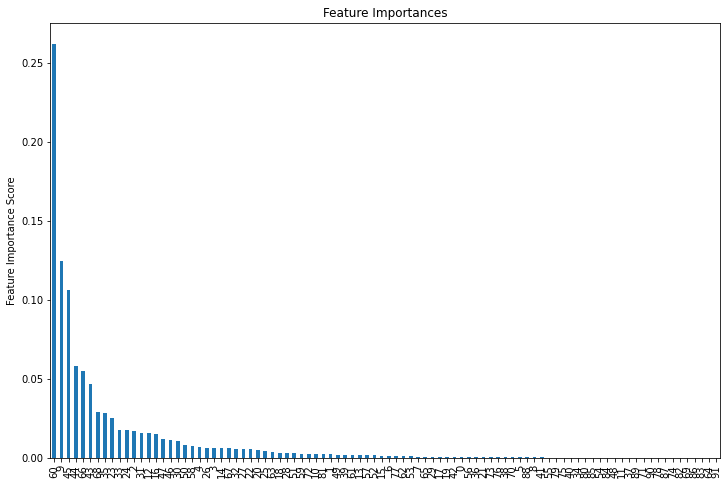

In [13]:
func_= Model(train, test)
prediction, model, redundant = func_()

In [10]:
prediction

array([0, 2, 2, ..., 1, 1, 2])

In [23]:
func_= Model(train, test)

In [24]:
func_.make_submission_file('testing3')

(1307297, 29)
(1307297, 24)
(1307297, 27)
(1307297, 24)
(1170511, 23) (136786, 23)
(1170511, 23) (136786, 23)
(1170511, 92) (136786, 92)


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[0]	validation_0-mlogloss:2.16454
Will train until validation_0-mlogloss hasn't improved in 100 rounds.
[99]	validation_0-mlogloss:0.321188
Default score: None
Accuracy is: 0.8938420531046031
F1 is: 0.897622820476685
None
-----------------------FOLD 1---------------------
[0]	validation_0-mlogloss:2.16442
Will train until validation_0-mlogloss hasn't improved in 100 rounds.
[99]	validation_0-mlogloss:0.322216
Default score: None
Accuracy is: 0.8932345729639217
F1 is: 0.8973209272967764
None
-----------------------FOLD 2---------------------
[0]	validation_0-mlogloss:2.16407
Will train until validation_0-mlogloss hasn't improved in 100 rounds.
[99]	validation_0-mlogloss:0.316318
Default score: None
Accuracy is: 0.8958488180365823
F1 is: 0.8997252967497092
None
-----------------------FOLD 3---------------------
[0]	validation_0-mlogloss:2.1647
Will train until validation_0-mlogloss hasn't improved in 100 rounds.
[99]	validation_0-mlogloss:0.318528
Default score: None
Accuracy is: 0.89502

In [18]:
a = pd.read_csv('/content/drive/My Drive/FORCE-Lithology-Prediction/testing2.csv')
 
a['# lithology'].value_counts()

65000    99960
30000    25604
65030     5995
70000     4537
80000      435
99000      157
90000       76
86000       12
70032       10
Name: # lithology, dtype: int64

In [25]:
a = pd.read_csv('/content/drive/My Drive/FORCE-Lithology-Prediction/testing3.csv')
 
a['# lithology'].value_counts()

65000    97195
30000    23976
65030     8970
70000     4808
99000      985
80000      425
90000      405
86000       22
Name: # lithology, dtype: int64